Each team will develop a machine learning model using those available in `scikit-learn` to predict whether or not a particular will elect to stop services provided by a financial institution based on known attributes. The first five rows of the training data are shown below.

In [49]:
import pandas as pd

train = pd.read_csv('train.csv')
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,597,Germany,Female,35,8,131101.04,1,1,1,192852.67,0
1,523,France,Female,40,2,102967.41,1,1,0,128702.10,1
2,706,Spain,Female,42,8,95386.82,1,1,1,75732.25,0
3,788,France,Male,32,4,112079.58,1,0,0,89368.59,0
4,706,Germany,Male,38,5,163034.82,2,1,1,135662.17,0


Each team will deploy there models to Azure. Specifically, each team should use `Flask` to deploy a web service that can accept JSON payloads via a `post` request. An example of a typical JSON payload that should be expected is shown below.

In [50]:
target = 'Exited'
features = [col for col in train.columns if col != target]

train[features].loc[0].to_dict()

{'CreditScore': 597,
 'Geography': 'Germany',
 'Gender': 'Female',
 'Age': 35,
 'Tenure': 8,
 'Balance': 131101.04,
 'NumOfProducts': 1,
 'HasCrCard': 1,
 'IsActiveMember': 1,
 'EstimatedSalary': 192852.67}

**This will be a graded assignment!** Points will be allocated as follows:
- 70 points for a working deployment
- 20 points for a model that achieves a predictive accuracy greater than 80%.
- 10 points based on competition

The model competition will take place on Monday, 2/21. Each model will be asked to make predictions for > 30 unseen customers. The winning model will be the one that achieves the **highest predictive accuracy**. Teams with the **best and worst** performing models will give a overview of their modeling pipeline (all teams should be prepared to speak to this). This overview should include discussions on:
- data preparation steps,
- model selection, and
- model tuning.

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import json

from sklearn.svm import SVC
from sklearn.feature_selection import RFE

#### First, we will explore the data by examining the distributions of each variable.

## Create Dummy Variables

In [52]:
for col in train.columns:
    if train[col].dtype == 'object':
        temp = pd.get_dummies(train[col], prefix=col, drop_first=True)
        train = train.drop(columns=[col])
        train[temp.columns] = temp

In [53]:
train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,597,35,8,131101.04,1,1,1,192852.67,0,1,0,0
1,523,40,2,102967.41,1,1,0,128702.10,1,0,0,0
2,706,42,8,95386.82,1,1,1,75732.25,0,0,1,0
3,788,32,4,112079.58,1,0,0,89368.59,0,0,0,1
4,706,38,5,163034.82,2,1,1,135662.17,0,1,0,1


## Create a training and validation set

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
target = 'Exited'
features = [col for col in train.columns if col != target]
binary_columns = [col for col in features if sorted(train[col].unique().tolist()) == [0, 1]]

In [56]:
X = train[features].copy()
y = train['Exited']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=69,
)

## Scale the training and test sets

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [60]:
scaler_filepath = pathlib.Path('scaler_info.json')

scaler_dict  = {}
for feature, mean, scale in zip(features, scaler.mean_, scaler.scale_):
    if feature in binary_columns:
        scaler_dict[feature] = {
            'mean': 0,
            'std': 1,
        }
    else:
        scaler_dict[feature] = {
            'mean': mean,
            'std': scale,
        }
        
with open(scaler_filepath, 'w') as fout:
    json.dump(scaler_dict, fout)

In [61]:
for col, col_params in scaler_dict.items():
    X_train.loc[:, col] = (X_train.loc[:, col] - col_params['mean'])/col_params['std']
    X_test.loc[:, col] = (X_test.loc[:, col] - col_params['mean'])/col_params['std']

In [62]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7190,0.205519,0.295855,0.345994,0.578300,-0.915802,1.0,1.0,-0.605431,0.0,0.0,0.0
5260,-2.385540,-0.470375,-1.386757,0.950210,-0.915802,0.0,0.0,0.852604,1.0,0.0,0.0
7223,-0.758355,-0.757711,0.345994,-1.221216,-0.915802,1.0,1.0,1.669385,0.0,1.0,1.0
736,-0.976004,1.157863,1.039094,-0.238360,-0.915802,1.0,0.0,1.711428,0.0,0.0,0.0
4788,-1.328388,-1.332383,-1.386757,0.563858,-0.915802,1.0,1.0,1.187024,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4374,-0.022494,-0.278818,1.039094,1.132727,0.813353,1.0,1.0,0.514403,0.0,1.0,1.0
8631,-2.281898,-0.757711,-0.000556,-1.221216,-0.915802,1.0,0.0,-0.084138,0.0,0.0,1.0
9818,-0.613256,-0.470375,-0.693657,0.318684,-0.915802,0.0,0.0,-1.210039,0.0,0.0,0.0
4041,0.081148,-0.278818,-1.386757,-1.221216,0.813353,0.0,1.0,-0.270870,0.0,1.0,1.0


## Logistic Regression

Start with all variables and try a backwards selection.

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
lclf = LogisticRegression(random_state=0).fit(X_train, y_train)
lclf.score(X_test, y_test)

0.8022462896109106

In [65]:
lclf.predict(X_test)[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [66]:
lclf.predict_proba(X_test)[:10]

array([[0.90875684, 0.09124316],
       [0.96787949, 0.03212051],
       [0.78343571, 0.21656429],
       [0.61183929, 0.38816071],
       [0.80865227, 0.19134773],
       [0.93001183, 0.06998817],
       [0.94249577, 0.05750423],
       [0.76700228, 0.23299772],
       [0.93206036, 0.06793964],
       [0.60846315, 0.39153685]])

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

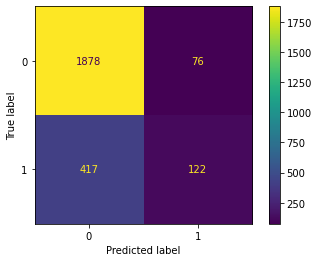

In [68]:
predictions = lclf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=lclf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=lclf.classes_,
)
disp.plot()
plt.show()

In [69]:
(1878+122)/(1878+122+76+417)

0.8022462896109106

In [70]:
threshold = .54
mod_predictions = (lclf.predict_proba(X_test)[:, 1] >= threshold).astype(int)

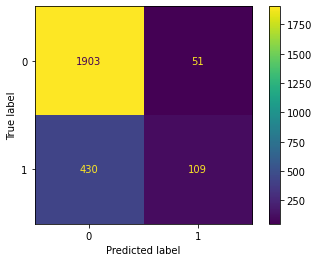

In [71]:
cm = confusion_matrix(y_test, mod_predictions, labels=lclf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=lclf.classes_,
)
disp.plot()
plt.show()

In [72]:
(1903+109)/(1903+109+51+430)

0.807059767348576

# Decision Tree

In [73]:
from sklearn import tree 
dclf = tree.DecisionTreeClassifier() 
dclf = dclf.fit(X_train, y_train) 
dclf.score(X_test, y_test)

0.7906137184115524

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10], 
}

dclf = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), params, error_score=0)
search = dclf.fit(X_train, y_train)
best_params = search.best_params_ 
best_params

{'criterion': 'entropy', 'max_depth': 6}

In [76]:
from sklearn import tree 
dclf = tree.DecisionTreeClassifier(random_state=0, **best_params) 
dclf = dclf.fit(X_train, y_train) 
dclf.score(X_test, y_test)

0.8515844364219816

# Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
params = {
    'criterion': ['entropy'], 
    'max_depth': [13], 
    'n_estimators': [100], 
}

rclf = GridSearchCV(RandomForestClassifier(random_state=0), params, error_score=0)
search = rclf.fit(X_train, y_train)
best_params = search.best_params_ 
best_params

rclf = RandomForestClassifier(random_state=0, **best_params)
rclf = rclf.fit(X_train, y_train) 
rclf.score(X_test, y_test)

0.8616125150421179

In [79]:
best_params

{'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 100}

# Ada Boost

In [80]:
from sklearn.ensemble import AdaBoostClassifier 

params = {
    'n_estimators': [10, 100, 200],
    'learning_rate': [0.25, 0.5, 1.0, 2.0],
}    

aclf = GridSearchCV(AdaBoostClassifier(random_state=0), params, error_score=0)
search = aclf.fit(X_train, y_train)
best_params = search.best_params_ 

aclf = AdaBoostClassifier(random_state=0, **best_params) 
aclf = aclf.fit(X_train, y_train) 
aclf.score(X_test, y_test)

0.8451664661050943

# Voting Classifier

Different approach: Make weights correspond with their predictive accuracy

In [81]:
type(rclf.score(X_test, y_test))

numpy.float64

In [82]:
scores = [lclf.score(X_test, y_test), rclf.score(X_test, y_test)]
proportions = []
sum_scores = sum(scores)
for score in scores:
    proportions.append(score/sum_scores)


In [83]:
proportions

[0.4821600771456124, 0.5178399228543876]

In [84]:
from sklearn.ensemble import VotingClassifier

In [85]:
print(f'Fitting Voting Classifier')
params = {
    'voting': ['hard', 'soft'],
    'weights': [proportions],
}    

eclf = VotingClassifier(
    estimators=[('rf', rclf), ('lr', lclf)], 
)

print('finding best params')
clf = GridSearchCV(eclf, params, error_score=0)
search = clf.fit(X_train, y_train)
best_params = search.best_params_ 
best_params

Fitting Voting Classifier
finding best params


{'voting': 'soft', 'weights': [0.4821600771456124, 0.5178399228543876]}

In [86]:
print('Doing vote')
eclf = VotingClassifier(
    estimators=[('rf', rclf), ('lr', lclf)], 
    **best_params
)

eclf = eclf.fit(X_train, y_train)
eclf.score(X_test, y_test)

Doing vote


0.8447653429602888